In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [8]:
image_paths_1 = ["images/left_1.jpg", "images/center_1.jpg", "images/right_1.jpg"]
images = [cv2.imread(p) for p in image_paths_1 if p is not None]

In [9]:
orb = cv2.ORB_create()

def detect_keypoints(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    keypoints, descriptors = orb.detectAndCompute(gray, None)
    return keypoints, descriptors

keypoints_list, descriptors_list = zip(*[detect_keypoints(img) for img in images])

In [10]:
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

matches_list = []
for i in range(len(images) - 1):
    matches = bf.match(descriptors_list[i], descriptors_list[i+1])
    matches_list.append(sorted(matches, key=lambda x: x.distance))

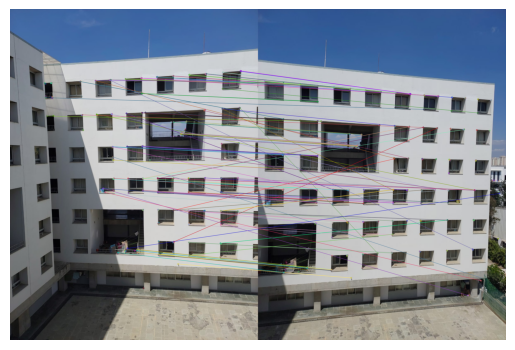

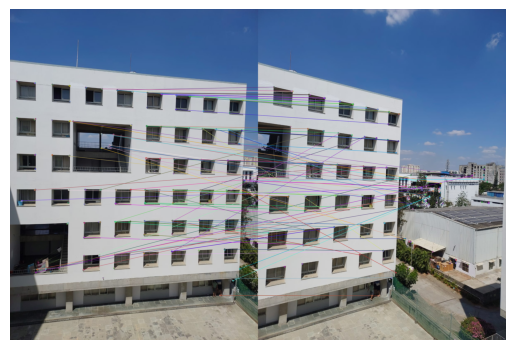

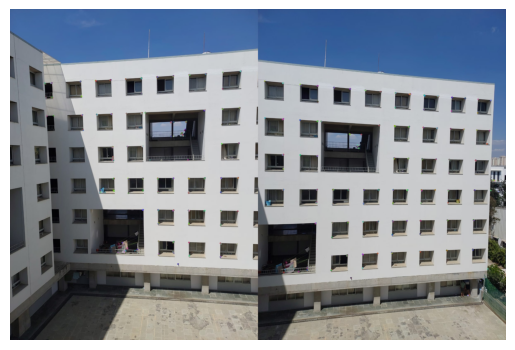

In [11]:
# Showing matched features in each image
for i in range(len(images) - 1):
    img1 = images[i]
    img2 = images[i+1]
    matches = matches_list[i]

    img_matches = cv2.drawMatches(img1, keypoints_list[i], img2, keypoints_list[i+1], matches, None)
    img_matches = cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

    plt.imshow(img_matches)
    plt.axis("off")  # Optional: remove axes for a cleaner display
    plt.show()

# Showing matched features in all images
matches = matches_list[0]
for i in range(1, len(images) - 1):
    matches = [m for m in matches if m in matches_list[i]]

img_matches = cv2.drawMatches(images[0], keypoints_list[0], images[1], keypoints_list[1], matches, None)
img_matches = cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

plt.imshow(img_matches)
plt.axis("off")
plt.show()


In [12]:
homographies = []
for i, matches in enumerate(matches_list):
    src_pts = np.float32([keypoints_list[i][m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints_list[i+1][m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
    H, _ = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)
    homographies.append(H)

In [13]:
panorama = images[0]

for i in range(1, len(images)):
    H = homographies[i - 1]
    h1, w1 = panorama.shape[:2]
    h2, w2 = images[i].shape[:2]
    warped_img = cv2.warpPerspective(images[i], H, (w1 + w2, h1))
    warped_img[0:h1, 0:w1] = panorama
    panorama = warped_img

# Crop black areas
gray_panorama = cv2.cvtColor(panorama, cv2.COLOR_BGR2GRAY)
_, thresh = cv2.threshold(gray_panorama, 1, 255, cv2.THRESH_BINARY)
coords = cv2.findNonZero(thresh)
x, y, w, h = cv2.boundingRect(coords)
panorama = panorama[y:y+h, x:x+w]

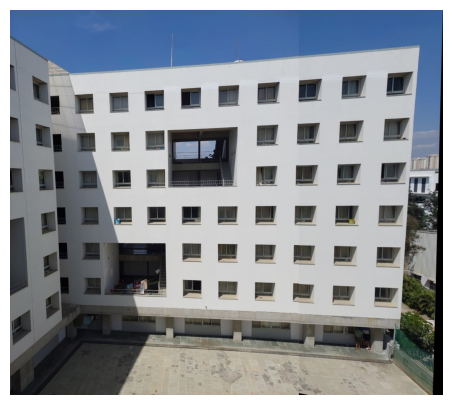

In [14]:
plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [15]:
cv2.imwrite("outputs/panorama.jpg", panorama)

True

In [ ]:
# make function for entire thing combined(give only output, with taking array of image paths as input)

def stitch_images(image_paths):
    images = [cv2.imread(p) for p in image_paths if p is not None]

    orb = cv2.ORB_create()

    def detect_keypoints(image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        keypoints, descriptors = orb.detectAndCompute(gray, None)
        return keypoints, descriptors

    keypoints_list, descriptors_list = zip(*[detect_keypoints(img) for img in images])

    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    matches_list = []
    for i in range(len(images) - 1):
        matches = bf.match(descriptors_list[i], descriptors_list[i+1])
        matches_list.append(sorted(matches, key=lambda x: x.distance))

    matches = matches_list[0]
    for i in range(1, len(images) - 1):
        matches = [m for m in matches if m in matches_list[i]]

    homographies = []
    for i, matches in enumerate(matches_list):
        src_pts = np.float32([keypoints_list[i][m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([keypoints_list[i+1][m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
        H, _ = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)
        homographies.append(H)

    panorama = images[0]

    for i in range(1, len(images)):
        H = homographies[i - 1]
        h1, w1 = panorama.shape[:2]
        h2, w2 = images[i].shape[:2]
        warped_img = cv2.warpPerspective(images[i], H, (w1 + w2, h1))
        warped_img[0:h1, 0:w1] = panorama
        panorama = warped_img

    # Crop black areas
    gray_panorama = cv2.cvtColor(panorama, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray_panorama, 1, 255, cv2.THRESH_BINARY)
    coords = cv2.findNonZero(thresh)
    x, y, w, h = cv2.boundingRect(coords)
    panorama = panorama[y:y+h, x:x+w]

    return panorama

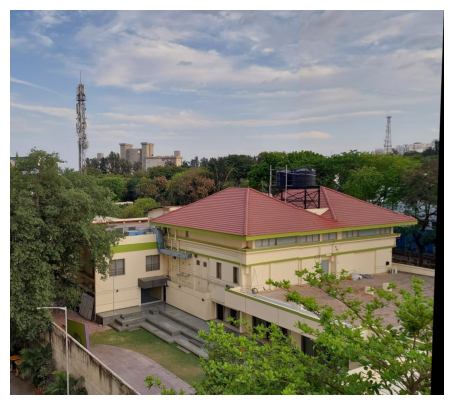

In [18]:
image_paths_2 = ["images/left_2.jpg", "images/center_2.jpg", "images/right_2.jpg"]

panorama = stitch_images(image_paths_2)

plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


In [ ]:
# function to save output image
def save_panorama(image_paths, output_path):
    panorama = stitch_images(image_paths)
    cv2.imwrite(output_path, panorama)